In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats

def coverage_and_width(low, up, y_test):
    width = up - low
    coverage = np.mean((low <= y_test) & (y_test <= up))
    return width.mean(), coverage.mean()

def boundary_adjustment(value, label_set, threshold=0.1):
    threshold_max = (label_set[-1] - label_set[0]) / (len(label_set) - 1) / 2
    threshold = min(threshold_max, threshold)
    adjusted_value = next((num for num in label_set if abs(num - value) < threshold), value)
    
    return adjusted_value

def process_directory(directory, dataset, adjustment=0.0):
    results = []
    if dataset == 'Summeval' or dataset == 'Dialsumm':
        dimensions = ['consistency', 'coherence', 'fluency', 'relevance']
        label_set = np.array([1, 1.33, 1.67, 2, 2.33, 2.67, 3, 3.33, 3.67, 4, 4.33, 4.67, 5])
    elif dataset == 'GEval' or dataset == 'SocREval':
        dimensions = ['cosmos', 'drop', 'esnli', 'gsm8k']
        label_set = np.array([1, 2, 3, 4, 5])
    
    for method_folder in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, method_folder)):
            for dimension in dimensions:
                for seed in range(1, 31): 
                    file_name = f"{method_folder}_{dataset}_{dimension}_{seed}.csv"
                    file_path = os.path.join(directory, method_folder, file_name)
                    
                    if os.path.exists(file_path):
                        data = pd.read_csv(file_path)
                        data = data.round(2)
                        if adjustment > 0:
                            data['low'] = data['low'].apply(lambda x: boundary_adjustment(x, label_set, adjustment))
                            data['up'] = data['up'].apply(lambda x: boundary_adjustment(x, label_set, adjustment))
                        width, coverage = coverage_and_width(data['low'], data['up'], data['y_test'])
                        results.append((method_folder, dataset, dimension, seed, width, coverage))
    
    return pd.DataFrame(results, columns=['Method', 'Dataset', 'Dimension', 'Seed' ,'Width', 'Coverage'])

def aggregate_results(df):
    aggregated = df.groupby(
        ['Method', 'Dataset', 'Dimension']
    ).agg({
        'Width':    ['mean', 'std'],
        'Coverage': ['mean', 'std']
    }).reset_index()

    aggregated.columns = [
        'Method', 'Dataset', 'Dimension',
        'Width_mean', 'Width_std',
        'Coverage_mean', 'Coverage_std'
    ]

    return aggregated[
        ['Method', 'Dataset', 'Dimension',
         'Width_mean', 'Width_std',
         'Coverage_mean', 'Coverage_std']
    ]

In [2]:
base_dir = os.getcwd()  
model = 'dsr1'
dataset = 'SocREval'
directory = os.path.join(base_dir, model)
results = process_directory(directory, dataset, adjustment=0.5)

results.to_csv(f'r2ccp_seed_{0.5}.csv', index=False)

In [3]:
tables = []

base_dir = os.getcwd()  
models = ['4omini', 'dsr1', 'qwen'] 
datasets = ['Summeval', 'Dialsumm', 'GEval', 'SocREval']
adjustment = 0
for model in models:
    for dataset in datasets:
        directory = os.path.join(base_dir, model)
        results = process_directory(directory, dataset)
        aggregated = aggregate_results(results)
        aggregated['Model']   = model
        aggregated['Dataset'] = dataset
        
        tables.append(aggregated)
        
df_all = pd.concat(tables, ignore_index=True)
df_all = df_all[~df_all['Method'].isin(['OrdinalAPS', 'OrdinalRC'])]
df_all.to_csv(f'Summary_continuous_{adjustment}.csv', index=False)
print(df_all)

          Method   Dataset    Dimension  Width_mean  Width_std  Coverage_mean  \
0    Boosted_cqr  Summeval    coherence    2.727860   0.100746       0.878042   
1    Boosted_cqr  Summeval  consistency    1.005083   0.081972       0.877500   
2    Boosted_cqr  Summeval      fluency    1.538255   0.126429       0.886833   
3    Boosted_cqr  Summeval    relevance    1.997400   0.097980       0.874208   
4    Boosted_lcp  Summeval    coherence    2.670884   0.045541       0.873417   
..           ...       ...          ...         ...        ...            ...   
419          LVD  SocREval        gsm8k    2.827943   0.399120       0.901333   
428        R2CCP  SocREval       cosmos    2.899571   0.517590       0.853401   
429        R2CCP  SocREval         drop    2.385213   0.585434       0.862540   
430        R2CCP  SocREval        esnli    1.589678   0.539659       0.845029   
431        R2CCP  SocREval        gsm8k    2.001470   1.039142       0.867333   

     Coverage_std   Model  

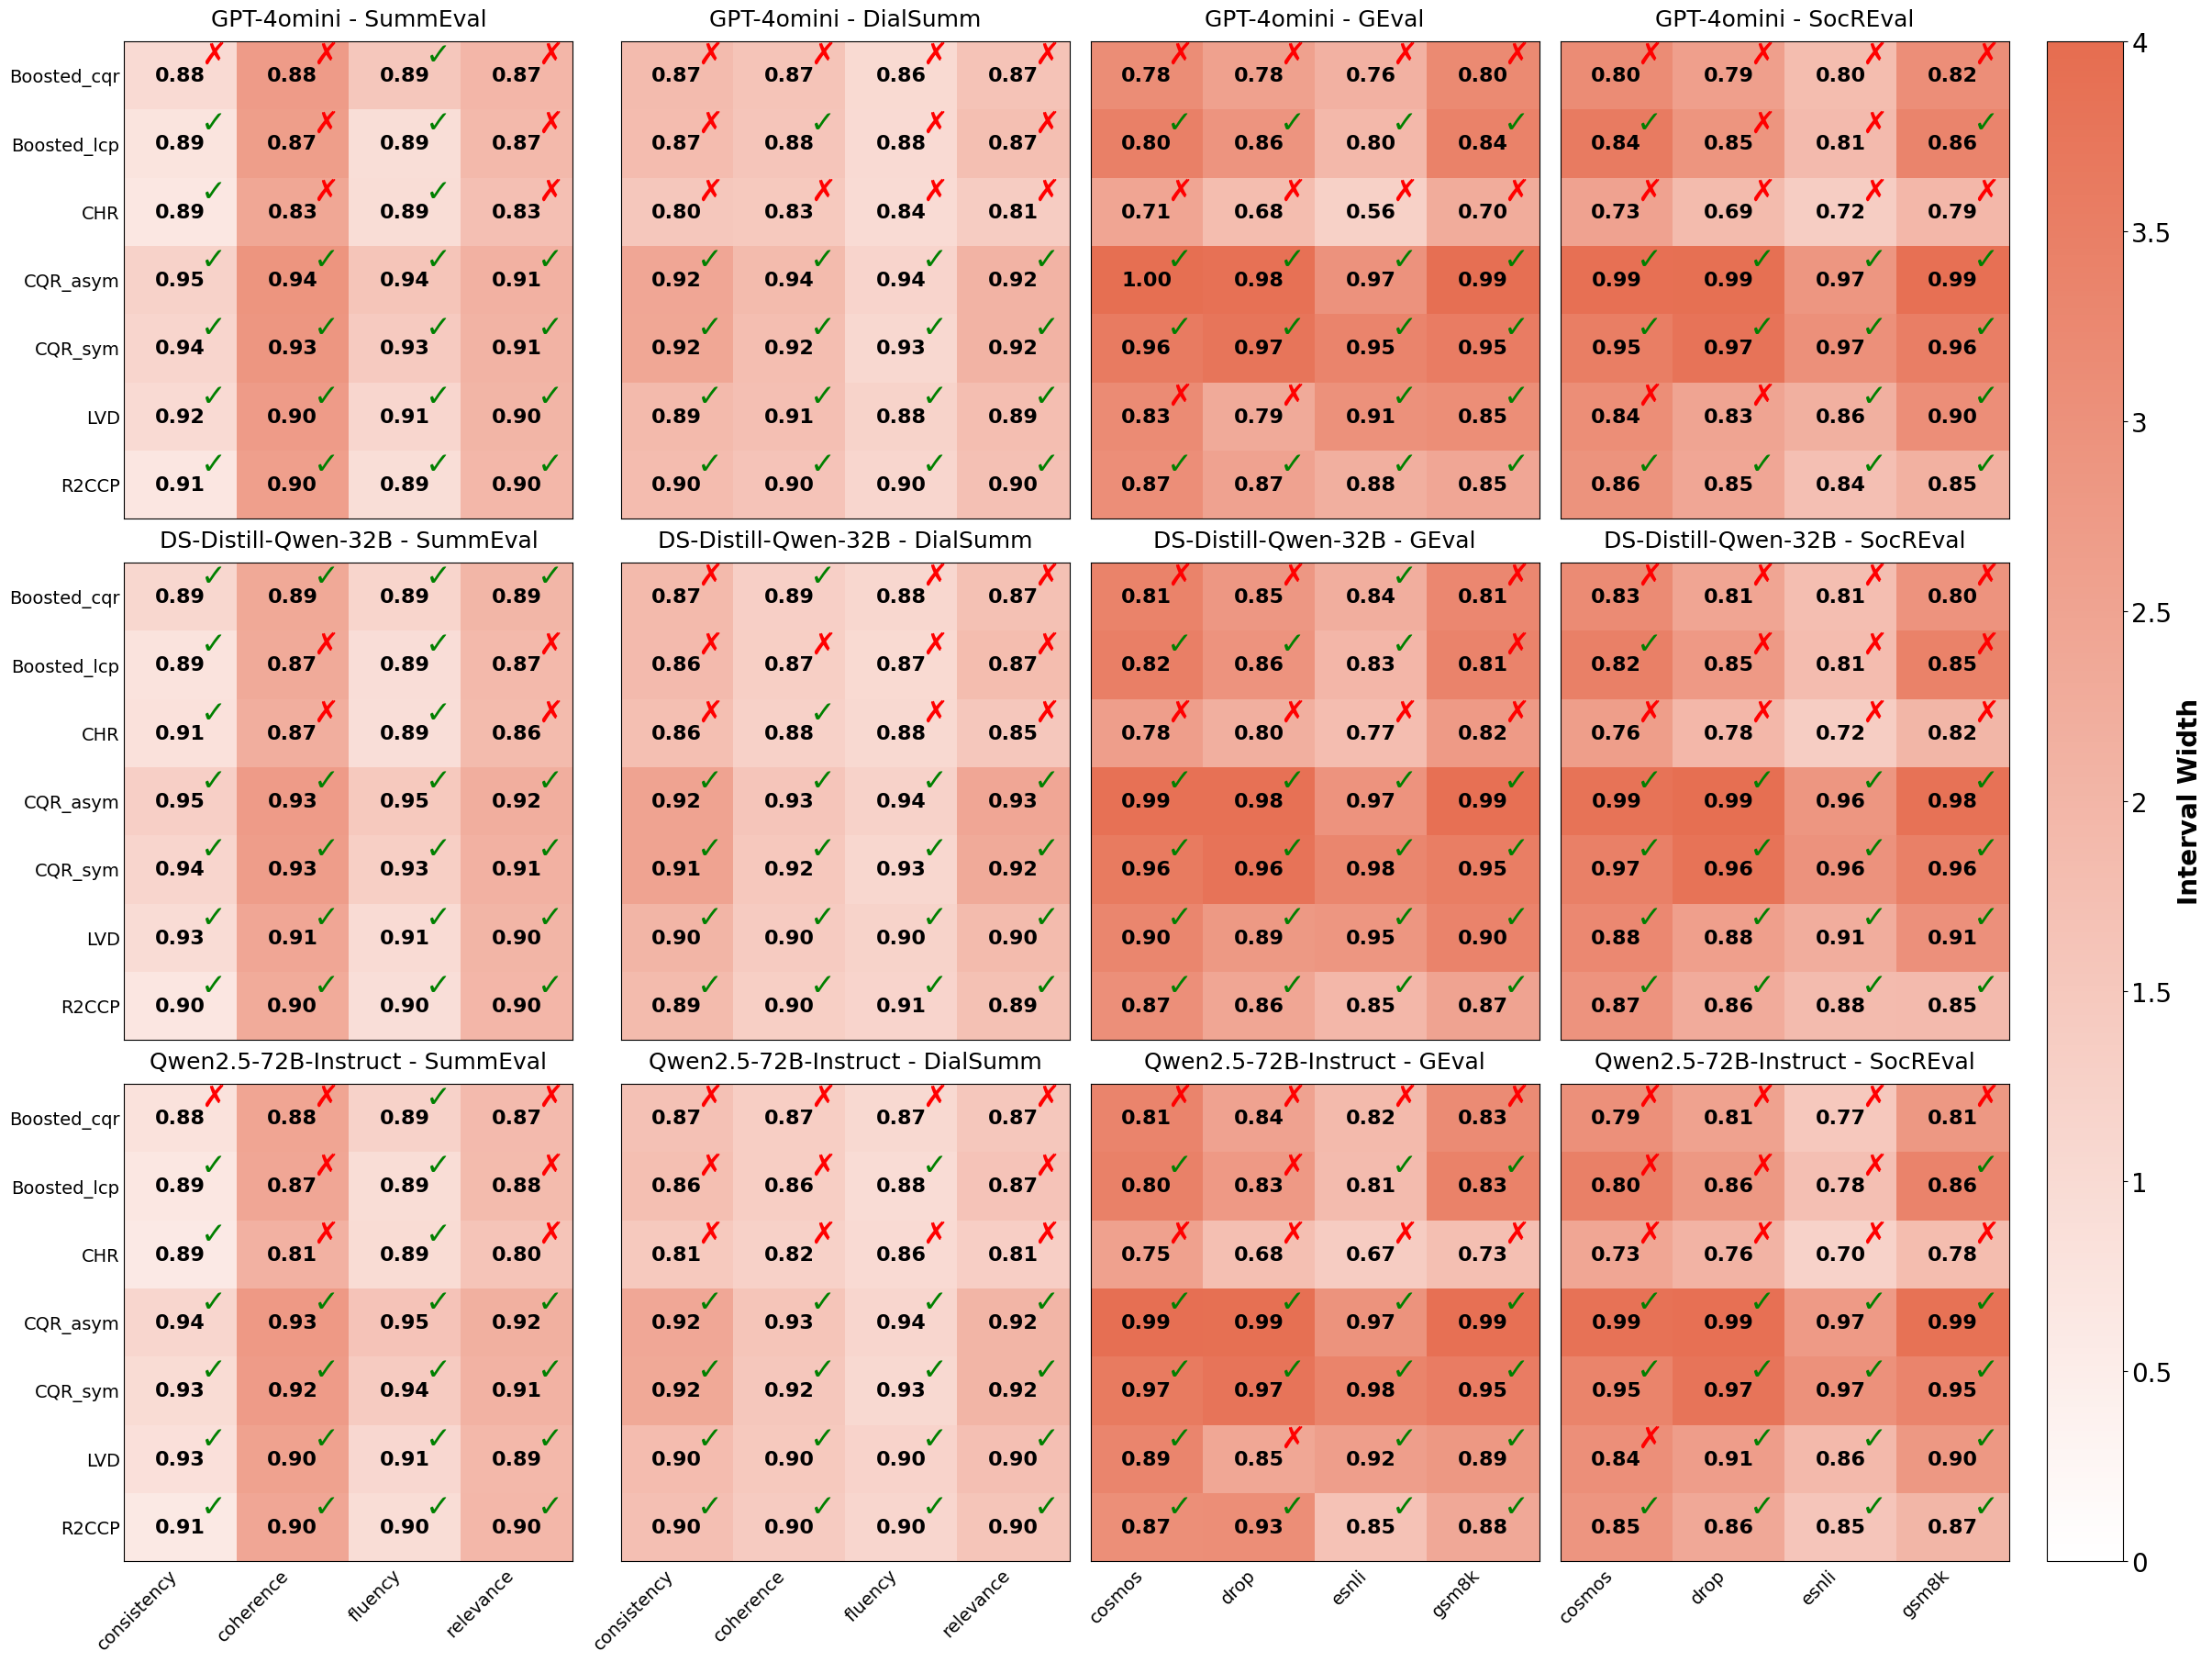

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

def plot_matrix_heatmaps_with_long_bar(df):
    # Label mappings
    model_labels = {'4omini': 'GPT-4omini','dsr1': 'DS-Distill-Qwen-32B','qwen': 'Qwen2.5-72B-Instruct'}
    dataset_labels = {'Summeval': 'SummEval','Dialsumm': 'DialSumm','GEval': 'GEval','SocREval': 'SocREval'}

    models = df['Model'].unique()
    datasets = df['Dataset'].unique()
    methods = df['Method'].unique()

    # Single base color
    base_hex = '#e66d50'
    base_rgb = tuple(int(base_hex.lstrip('#')[k:k+2], 16)/255. for k in (0,2,4))
    cmap = LinearSegmentedColormap.from_list('custom', [(1,1,1), base_rgb])

    fig, axes = plt.subplots(len(models), len(datasets), figsize=(24, 18), constrained_layout=True)
    norm = plt.Normalize(vmin=0, vmax=1)  # normalized width

    for i, model in enumerate(models):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]
            sub = df[(df['Model']==model)&(df['Dataset']==dataset)]
            dims = ['consistency','coherence','fluency','relevance'] if dataset in ['Summeval','Dialsumm'] \
                   else ['cosmos','drop','esnli','gsm8k']
            heatmap_data = sub.pivot(index='Method', columns='Dimension', values='Width_mean')
            data = heatmap_data.reindex(index=methods, columns=dims).values / 4.0  # normalize by max width 4

            for m_idx, method in enumerate(methods):
                for d_idx, dim in enumerate(dims):
                    width_norm = data[m_idx, d_idx]
                    color = cmap(norm(width_norm))
                    rect = Rectangle((d_idx-0.5, m_idx-0.5), 1, 1, facecolor=color, edgecolor='none')
                    ax.add_patch(rect)

                    cov_mean = sub.set_index(['Method','Dimension']).loc[(method,dim),'Coverage_mean']
                    cov_std  = sub.set_index(['Method','Dimension']).loc[(method,dim),'Coverage_std']
                    ax.text(d_idx, m_idx, f"{cov_mean:.2f}", ha='center', va='center', fontsize=16, fontweight='bold')

                    mark = '✓' if cov_mean+cov_std>=0.9 else '✗'
                    ax.text(d_idx+0.3, m_idx-0.3, mark, ha='center', va='center', fontsize=24, fontweight='bold',
                            color='green' if mark=='✓' else 'red')

            if j==0:
                ax.set_yticks(range(len(methods))); ax.set_yticklabels(methods, fontsize=14)
            else:
                ax.set_yticks([])
            if i==len(models)-1:
                ax.set_xticks(range(len(dims))); ax.set_xticklabels(dims, rotation=45, ha='right', fontsize=14)
            else:
                ax.set_xticks([])

            title = f"{model_labels[model]} - {dataset_labels[dataset]}"
            ax.set_title(title, fontsize=18, pad=12)
            ax.set_xlim(-0.5, len(dims)-0.5); ax.set_ylim(len(methods)-0.5, -0.5)
            ax.tick_params(length=0)

    tick_positions = [0/4,0.5/4,1/4, 1.5/4,2/4, 2.5/4,3/4, 3.5/4, 4/4]
    tick_labels    = ['0', '0.5','1','1.5','2','2.5','3','3.5', '4']

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(
        sm,
        ax=axes.ravel().tolist(),
        orientation='vertical',
        fraction=0.95,
        pad=0.02,
        ticks=tick_positions
    )
    cbar.ax.set_yticklabels(tick_labels, fontsize=20)
    cbar.set_label('Interval Width', fontsize=20, fontweight='bold')

    plt.show()

# To use:
plot_matrix_heatmaps_with_long_bar(df_all)


In [5]:
tables = []

base_dir = os.getcwd()  
models = ['4omini', 'dsr1', 'qwen'] 
datasets = ['Summeval', 'Dialsumm', 'GEval', 'SocREval']
adjustment = 0.1
for model in models:
    for dataset in datasets:
        directory = os.path.join(base_dir, model)
        results = process_directory(directory, dataset, adjustment)
        aggregated = aggregate_results(results)
        aggregated['Model']   = model
        aggregated['Dataset'] = dataset
        
        tables.append(aggregated)
        
df_all = pd.concat(tables, ignore_index=True)
df_all = df_all[~df_all['Method'].isin(['OrdinalAPS', 'OrdinalRC'])]
df_all.to_csv(f'Summary_continuous_{adjustment}.csv', index=False)
print(df_all)

          Method   Dataset    Dimension  Width_mean  Width_std  Coverage_mean  \
0    Boosted_cqr  Summeval    coherence    2.731776   0.104202       0.909375   
1    Boosted_cqr  Summeval  consistency    0.994560   0.076681       0.915625   
2    Boosted_cqr  Summeval      fluency    1.541532   0.126795       0.931458   
3    Boosted_cqr  Summeval    relevance    1.997492   0.097573       0.906583   
4    Boosted_lcp  Summeval    coherence    2.676279   0.044096       0.917125   
..           ...       ...          ...         ...        ...            ...   
419          LVD  SocREval        gsm8k    2.829110   0.398370       0.910667   
428        R2CCP  SocREval       cosmos    2.899864   0.520962       0.861565   
429        R2CCP  SocREval         drop    2.383175   0.588280       0.869206   
430        R2CCP  SocREval        esnli    1.585390   0.546737       0.854288   
431        R2CCP  SocREval        gsm8k    2.002630   1.042201       0.870667   

     Coverage_std   Model  

In [6]:
tables = []

base_dir = os.getcwd()  
models = ['4omini', 'dsr1', 'qwen'] 
datasets = ['Summeval', 'Dialsumm', 'GEval', 'SocREval']
adjustment = 0.5
for model in models:
    for dataset in datasets:
        directory = os.path.join(base_dir, model)
        results = process_directory(directory, dataset, adjustment)
        aggregated = aggregate_results(results)
        aggregated['Model']   = model
        aggregated['Dataset'] = dataset
        
        tables.append(aggregated)
        
df_all = pd.concat(tables, ignore_index=True)
# df_all = df_all[~df_all['Method'].isin(['OrdinalAPS', 'OrdinalRC'])]
df_all.to_csv(f'Summary_{adjustment}.csv', index=False)
print(df_all)

          Method   Dataset    Dimension  Width_mean  Width_std  Coverage_mean  \
0    Boosted_cqr  Summeval    coherence    2.732790   0.109264       0.930167   
1    Boosted_cqr  Summeval  consistency    0.989497   0.071990       0.928083   
2    Boosted_cqr  Summeval      fluency    1.544458   0.126382       0.943833   
3    Boosted_cqr  Summeval    relevance    1.999405   0.100813       0.929333   
4    Boosted_lcp  Summeval    coherence    2.678106   0.042602       0.935333   
..           ...       ...          ...         ...        ...            ...   
427    OrdinalRC  SocREval        gsm8k    0.492333   0.066056       0.713667   
428        R2CCP  SocREval       cosmos    2.878571   0.557161       0.892857   
429        R2CCP  SocREval         drop    2.344603   0.645919       0.900000   
430        R2CCP  SocREval        esnli    1.546053   0.628172       0.902047   
431        R2CCP  SocREval        gsm8k    1.960167   1.097025       0.885667   

     Coverage_std   Model  

In [7]:
adjustment = 0.5
df_all = pd.concat(tables, ignore_index=True)
df_all.to_csv(f'Summary_continuous_{adjustment}.csv', index=False)
print(df_all)

          Method   Dataset    Dimension  Width_mean  Width_std  Coverage_mean  \
0    Boosted_cqr  Summeval    coherence    2.732790   0.109264       0.930167   
1    Boosted_cqr  Summeval  consistency    0.989497   0.071990       0.928083   
2    Boosted_cqr  Summeval      fluency    1.544458   0.126382       0.943833   
3    Boosted_cqr  Summeval    relevance    1.999405   0.100813       0.929333   
4    Boosted_lcp  Summeval    coherence    2.678106   0.042602       0.935333   
..           ...       ...          ...         ...        ...            ...   
427    OrdinalRC  SocREval        gsm8k    0.492333   0.066056       0.713667   
428        R2CCP  SocREval       cosmos    2.878571   0.557161       0.892857   
429        R2CCP  SocREval         drop    2.344603   0.645919       0.900000   
430        R2CCP  SocREval        esnli    1.546053   0.628172       0.902047   
431        R2CCP  SocREval        gsm8k    1.960167   1.097025       0.885667   

     Coverage_std   Model  